In [1]:
%reload_ext autoreload
%autoreload 2

# Gaussian eddy

We want to use a gaussian eddy for our functional tests, as an analytical solution exists in that setting.

The gaussian eddy we consider is of the form $\eta = \eta_0 \exp^{-(r/R_0)^2}$, with $R_0=50km$ its radius, and $\eta_0=10cm$ its SSH at its center. 
We choose a constant spatial step of $3km$.

In [2]:
R0 = 100e3
dxy = 3e3
ETA0 = -.25
LAT = -19

## Simulating the eddy

In [3]:
import gaussian_eddy as ge 

X, Y, R, dXY, coriolis_factor, ssh, u_geos, v_geos, u_cyclo, v_cyclo = ge.simulate_gaussian_eddy(R0, dxy, ETA0, LAT)

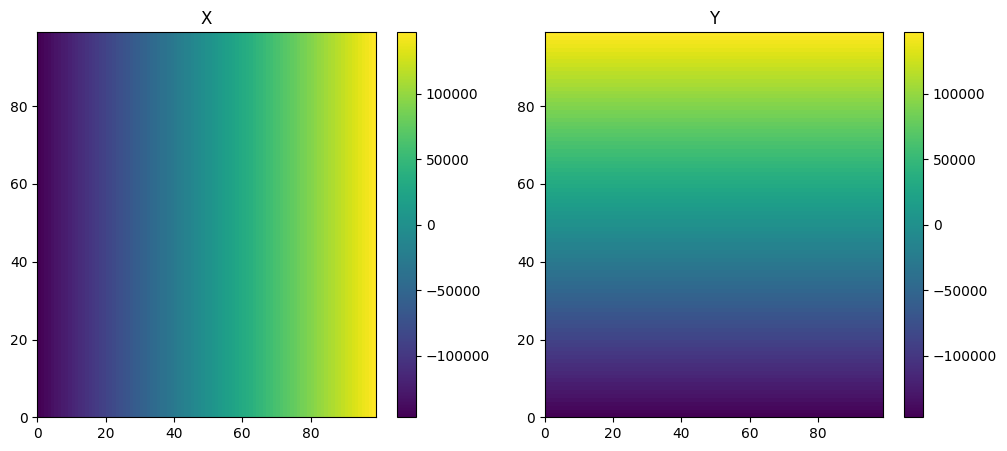

In [4]:
import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("X")
im = ax1.pcolormesh(X, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("Y")
im = ax2.pcolormesh(Y, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

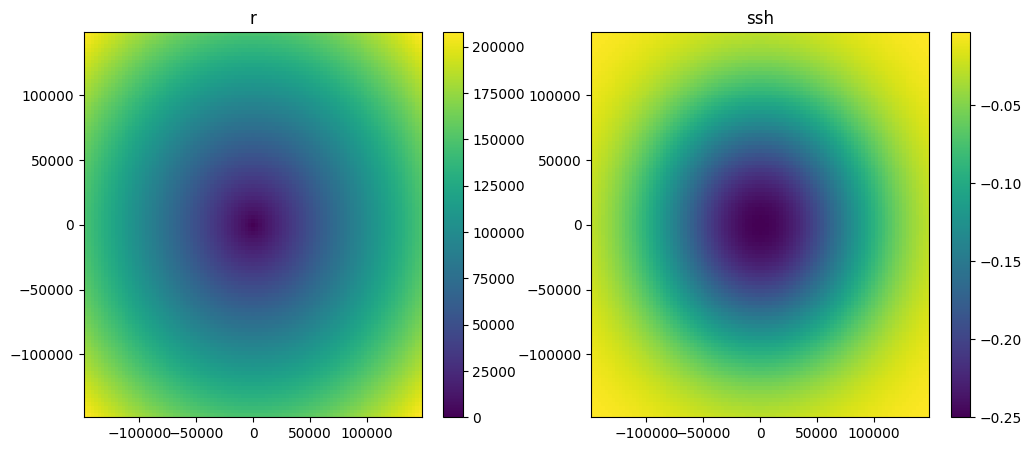

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("r")
im = ax1.pcolormesh(X, Y, R, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("ssh")
im = ax2.pcolormesh(X, Y, ssh, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

## Geostrophic azimuthal velocity

### Simulated

$$u_g = 2y \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = 2y \frac{g \eta}{f R_0^2}$$

$$v_g = -2x \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = -2x \frac{g \eta}{f R_0^2}$$

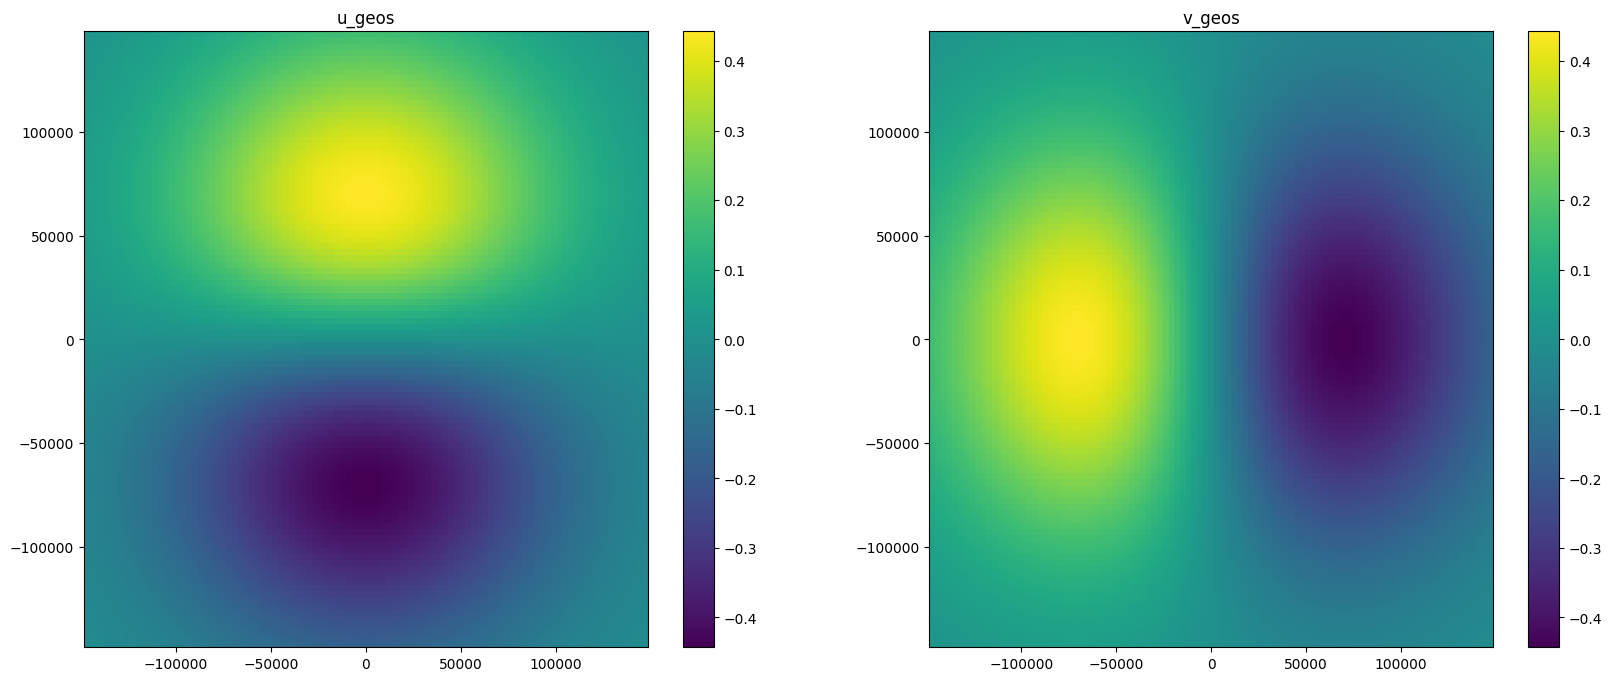

In [6]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("u_geos")
im = ax1.pcolormesh(X, Y, u_geos, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("v_geos")
im = ax2.pcolormesh(X, Y, v_geos, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

In [7]:
azim_geos = ge.compute_azimuthal_magnitude(u_geos, v_geos)

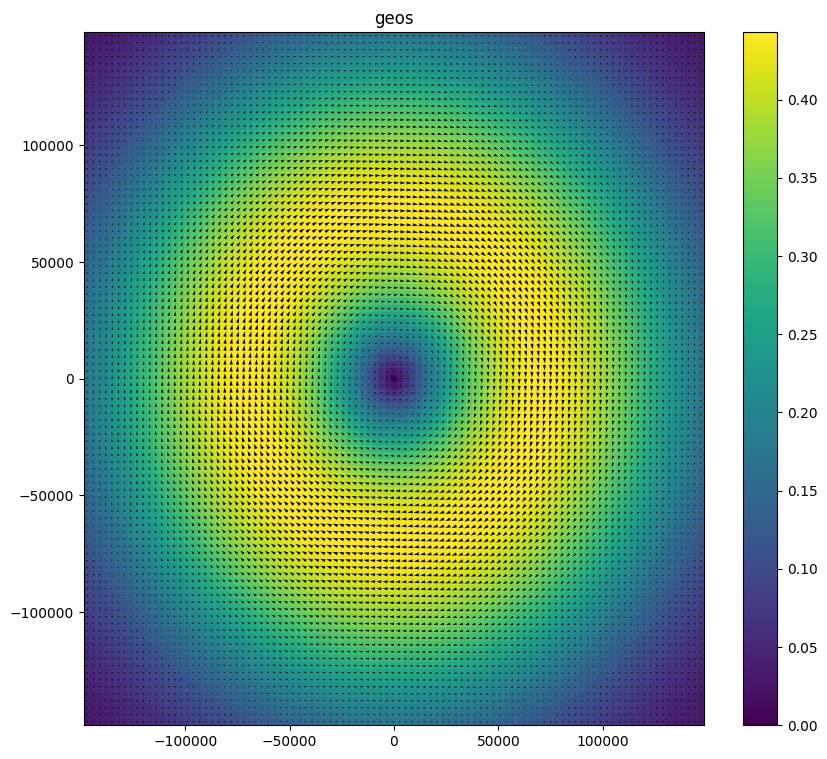

In [8]:
_, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_title("geos")
im = ax.pcolormesh(X, Y, azim_geos, shading="auto")
plt.colorbar(im, ax=ax)
ax.quiver(X, Y, u_geos, v_geos, color='k')
plt.show()

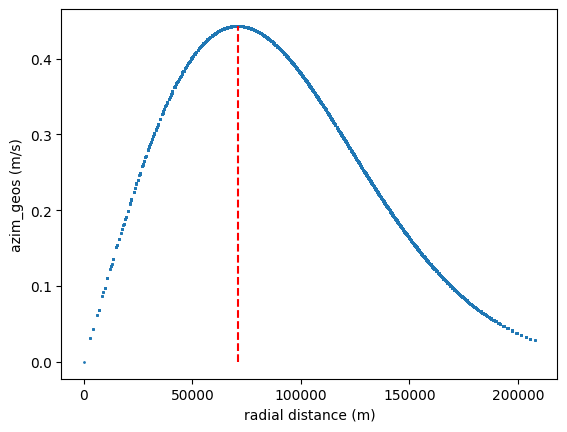

In [9]:
import numpy as np

ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_geos (m/s)")
ax.scatter(R.flatten(), azim_geos.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_geos).flatten().argmax()], 
          ymin=azim_geos.min(), ymax=azim_geos.max(), colors="r", linestyles="dashed")
plt.show()

### Geostrophic balance

$f\mathbf{k} \times \mathbf{u_g} = -g \nabla \eta$

In [10]:
import jaxparrow.geostrophy as geos

u_geos_est, v_geos_est = geos.geostrophy(ssh, dXY, dXY, coriolis_factor, coriolis_factor)

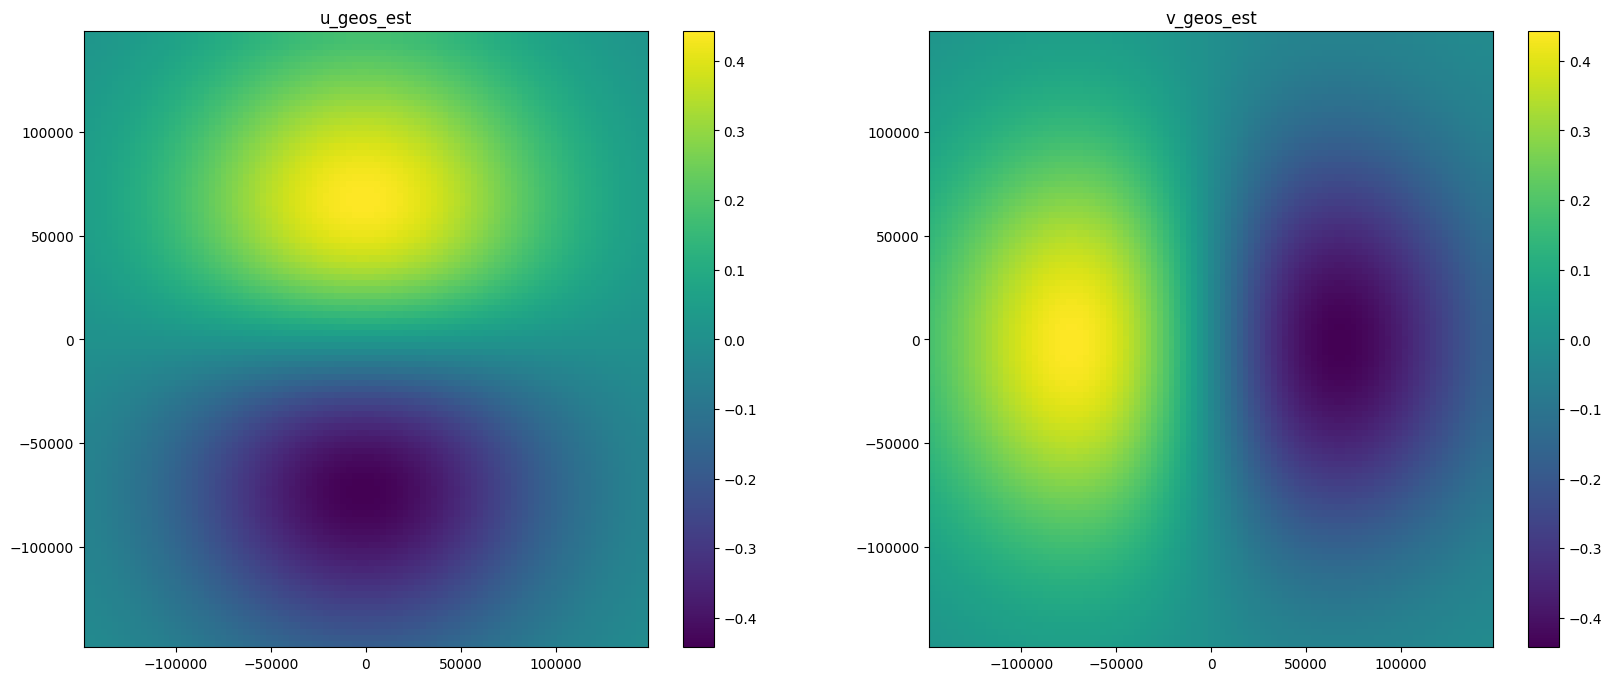

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("u_geos_est")
im = ax1.pcolormesh(X, Y, u_geos_est, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("v_geos_est")
im = ax2.pcolormesh(X, Y, v_geos_est, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

In [12]:
u_geos_est, v_geos_est = ge.reinterpolate(u_geos_est, axis=0), ge.reinterpolate(v_geos_est, axis=1)

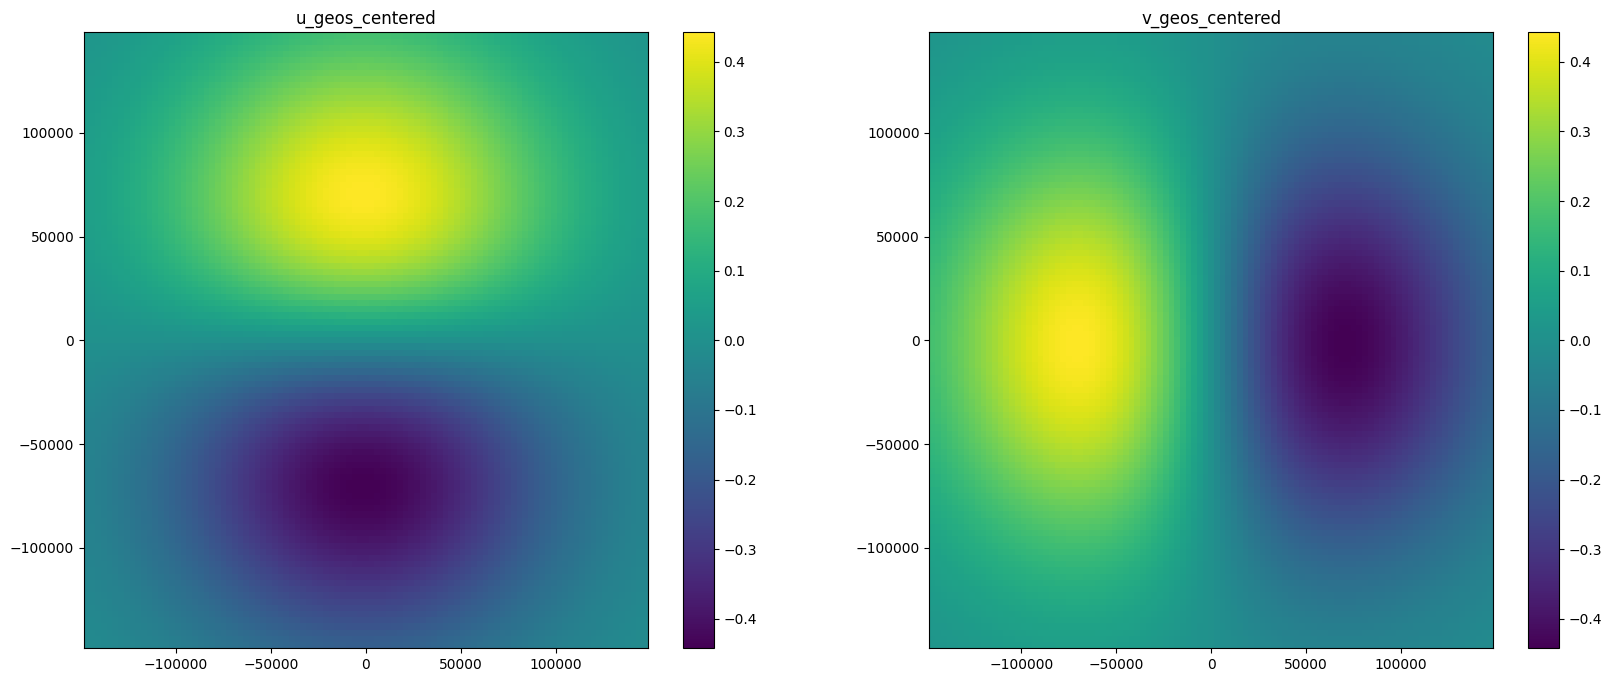

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("u_geos_centered")
im = ax1.pcolormesh(X, Y, u_geos_est, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("v_geos_centered")
im = ax2.pcolormesh(X, Y, v_geos_est, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

In [14]:
azim_geos_est = ge.compute_azimuthal_magnitude(u_geos_est, v_geos_est)

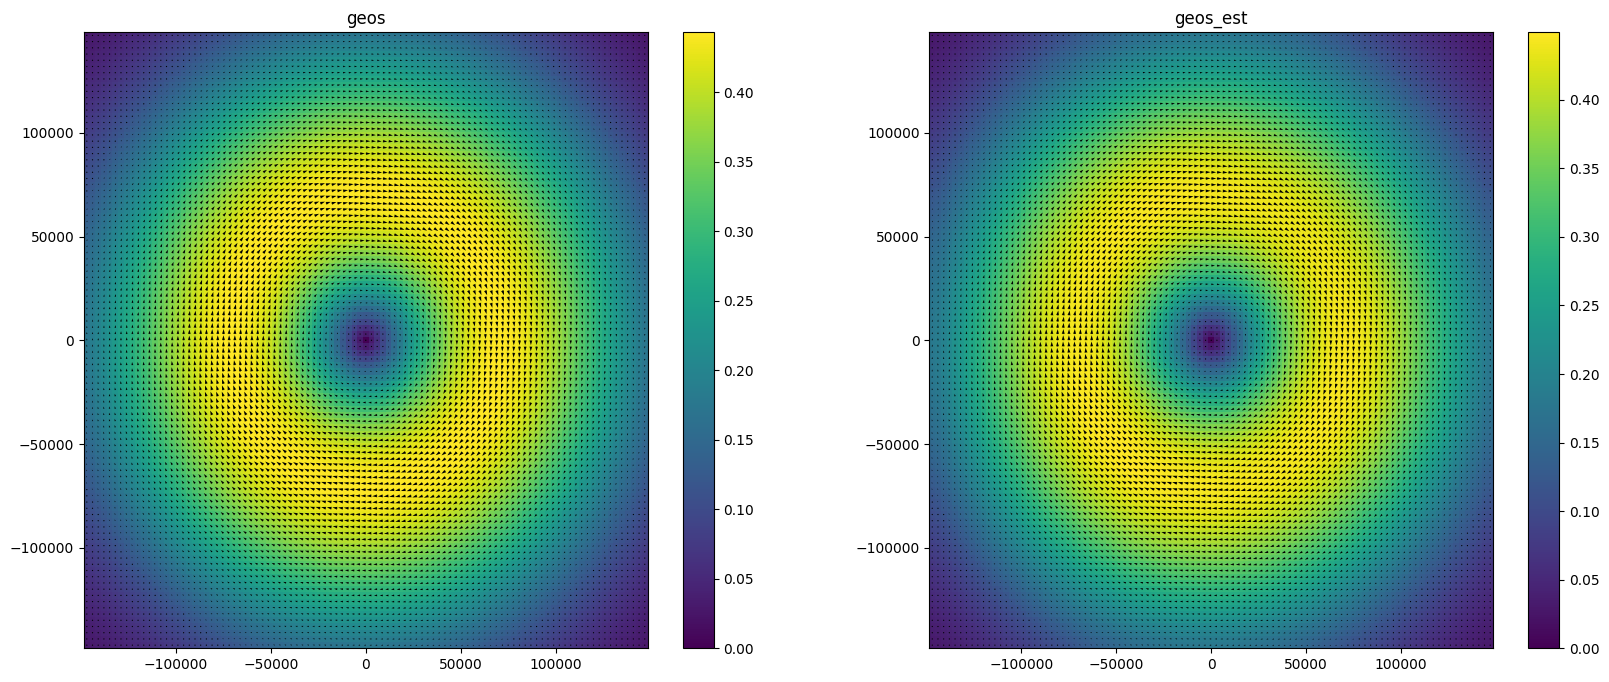

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("geos")
im = ax1.pcolormesh(X, Y, azim_geos, shading="auto")
plt.colorbar(im, ax=ax1)
ax1.quiver(X, Y, u_geos, v_geos, color='k')
ax2.set_title("geos_est")
im = ax2.pcolormesh(X, Y, azim_geos_est, shading="auto")
plt.colorbar(im, ax=ax2)
ax2.quiver(X, Y, u_geos_est, v_geos_est, color='k')
plt.show()

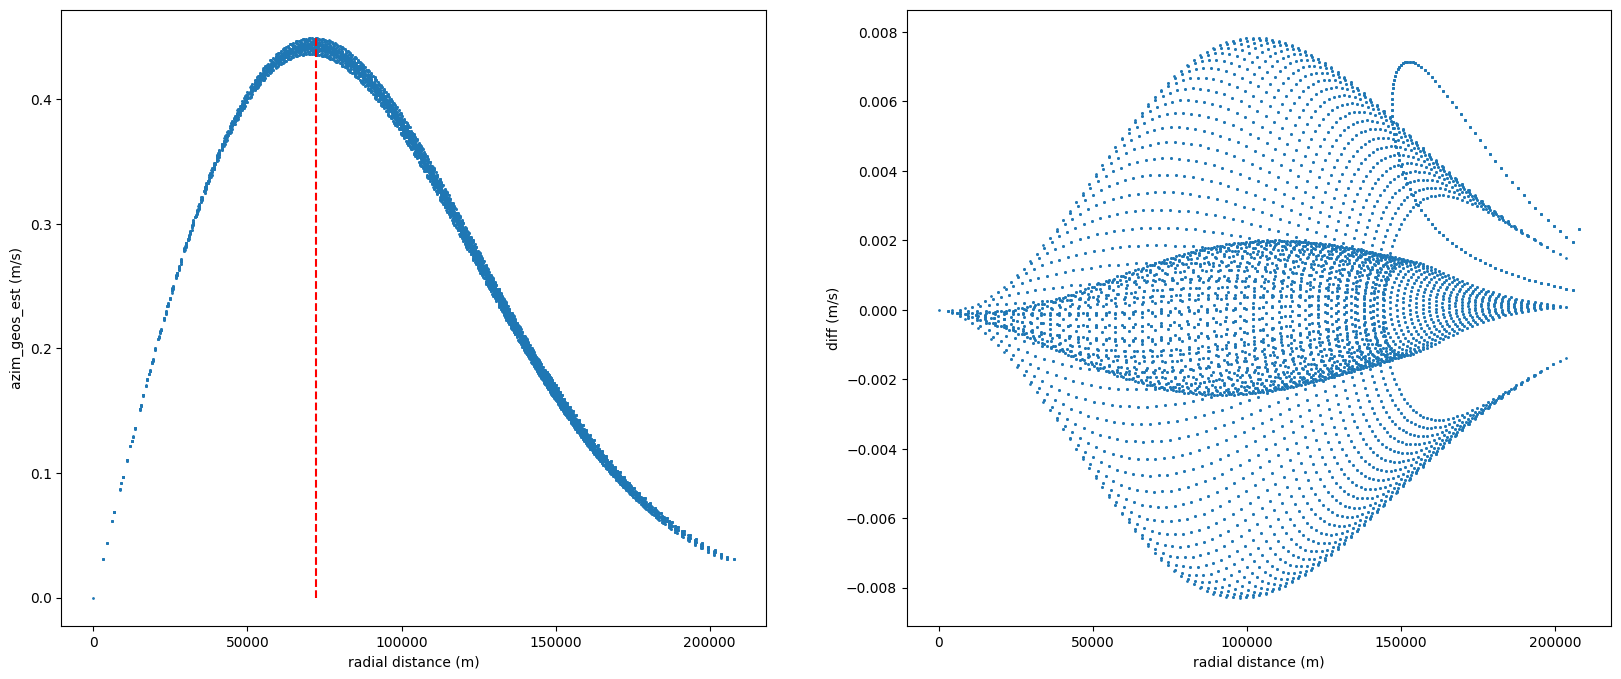

In [16]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_xlabel("radial distance (m)")
ax1.set_ylabel("azim_geos_est (m/s)")
ax1.scatter(R.flatten(), azim_geos_est.flatten(), s=1)
ax1.vlines(R.flatten()[np.abs(azim_geos_est).flatten().argmax()], 
           ymin=azim_geos_est.min(), ymax=azim_geos_est.max(), colors="r", linestyles="dashed")
ax2.set_xlabel("radial distance (m)")
ax2.set_ylabel("diff (m/s)")
ax2.scatter(R.flatten(), (azim_geos_est - azim_geos).flatten(), s=1)
plt.show()

In [17]:
np.std(azim_geos), ge.compute_rmse(azim_geos, azim_geos_est), ge.compute_mape(azim_geos, azim_geos_est), ge.compute_cor(azim_geos, azim_geos_est)

/home/bertrava/projects/jaxparrow/tests/gaussian_eddy.py:60: RuntimeWarning: invalid value encountered in divide
  ape = np.abs((vel - vel_est) / vel)


(0.12016635381789399,
 0.00328058242522915,
 0.011215017673637744,
 0.9996300486551608)

## Cyclogeostrophic azimuthal velocity

### Gradient wind analytical solution

$$V_{gr}=\frac{2V_g}{1+\sqrt{1+4V_g/(fR_0)}}$$

$$u_{gr} = u_g \frac{fR_0}{fR_0 - V_{gr}^2}$$
$$v_{gr} = v_g \frac{fR_0}{fR_0 - V_{gr}^2}$$

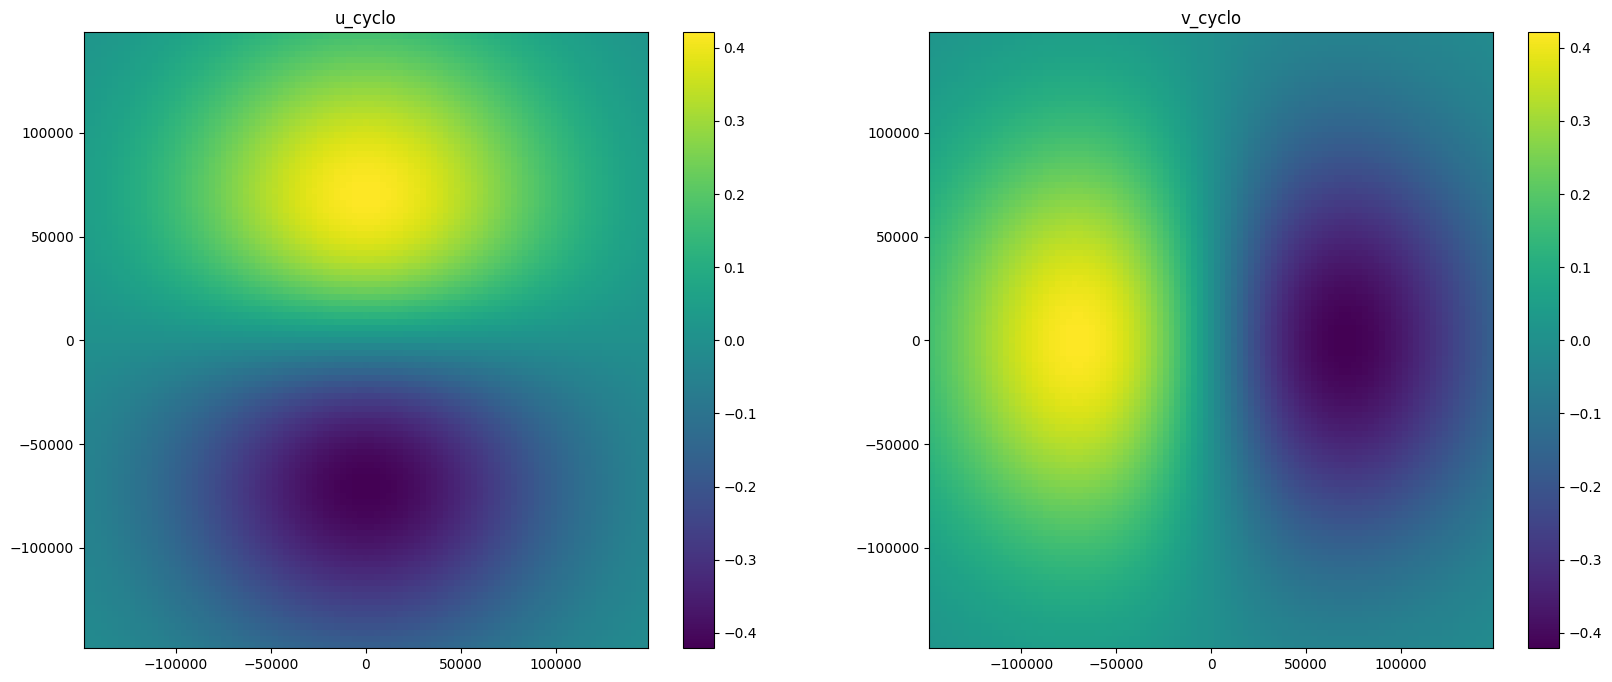

In [18]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("u_cyclo")
im = ax1.pcolormesh(X, Y, u_cyclo, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("v_cyclo")
im = ax2.pcolormesh(X, Y, v_cyclo, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

In [19]:
azim_cyclo = ge.compute_azimuthal_magnitude(u_cyclo, v_cyclo)

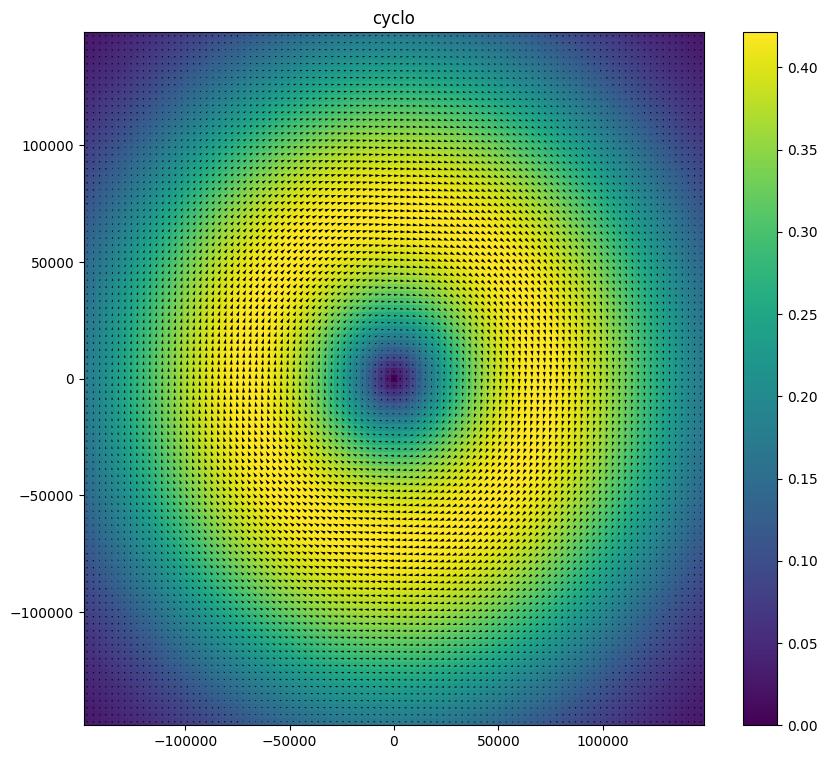

In [20]:
_, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_title("cyclo")
im = ax.pcolormesh(X, Y, azim_cyclo, shading="auto")
plt.colorbar(im, ax=ax)
ax.quiver(X, Y, u_cyclo, v_cyclo, color='k')
plt.show()

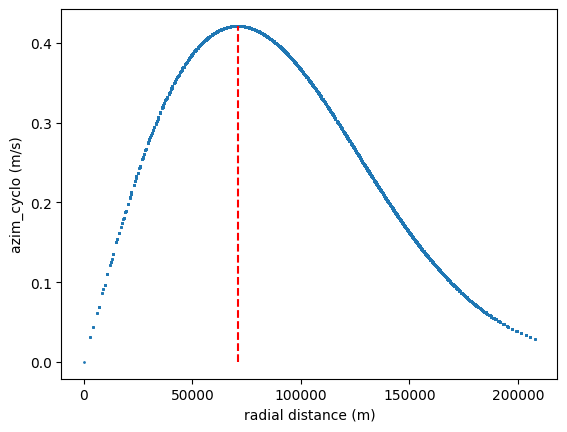

In [21]:
ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_cyclo (m/s)")
ax.scatter(R.flatten(), azim_cyclo.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo).flatten().argmax()], 
          ymin=azim_cyclo.min(), ymax=azim_cyclo.max(), colors="r", linestyles="dashed")
plt.show()

### Variational estimation

$\mathbf{u} - \frac{\mathbf{k}}{f} \times (\mathbf{u} \cdot \nabla \mathbf{u}) = \mathbf{u_g}$

In [22]:
import jaxparrow.cyclogeostrophy as cyclo

u_cyclo_est, v_cyclo_est = cyclo.variational(u_geos, v_geos, dXY, dXY, dXY, dXY, coriolis_factor, coriolis_factor)

100%|██████████| 2000/2000 [00:01<00:00, 1419.18it/s]


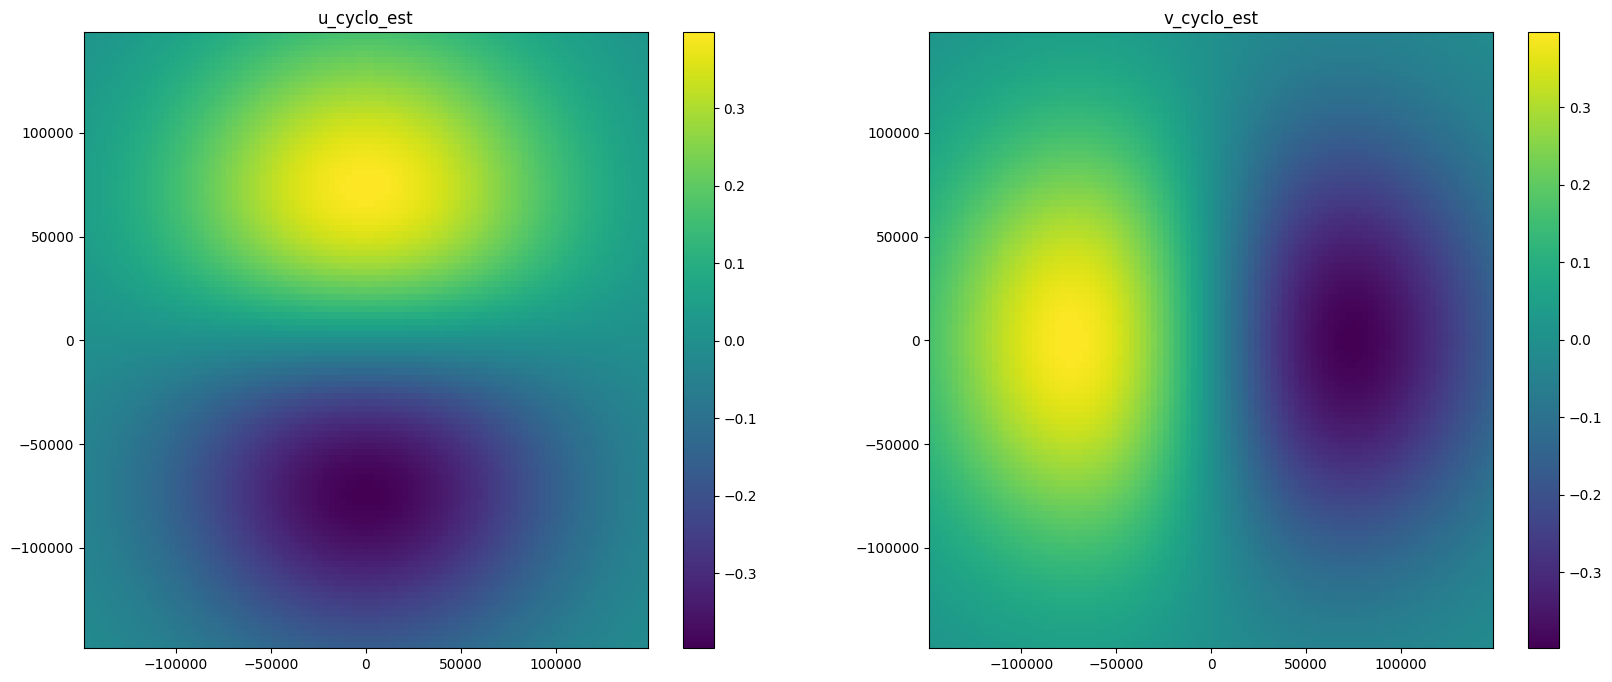

In [23]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("u_cyclo_est")
im = ax1.pcolormesh(X, Y, u_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("v_cyclo_est")
im = ax2.pcolormesh(X, Y, v_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

In [24]:
azim_cyclo_est = ge.compute_azimuthal_magnitude(u_cyclo_est, v_cyclo_est)

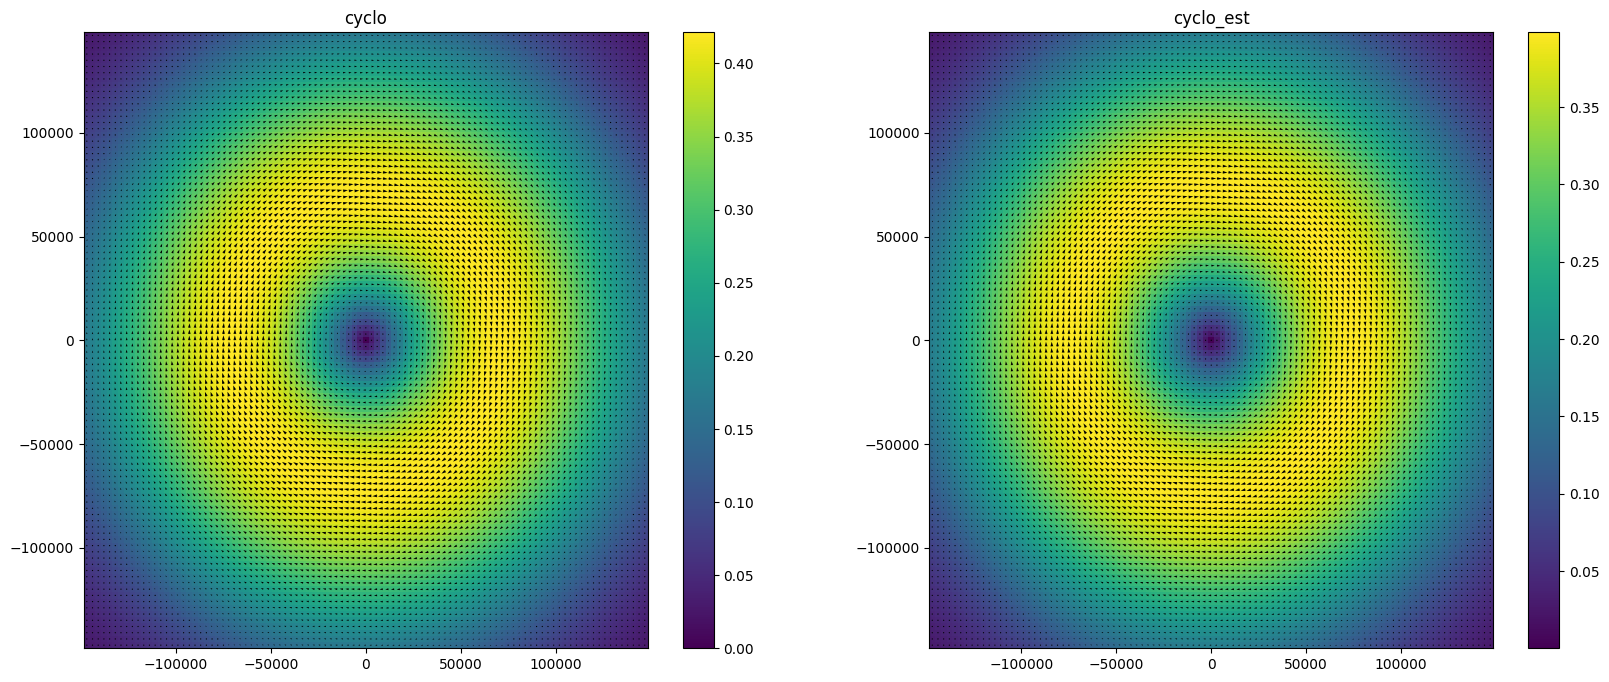

In [25]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("cyclo")
im = ax1.pcolormesh(X, Y, azim_cyclo, shading="auto")
plt.colorbar(im, ax=ax1)
ax1.quiver(X, Y, u_cyclo, v_cyclo, color='k')
ax2.set_title("cyclo_est")
im = ax2.pcolormesh(X, Y, azim_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax2)
ax2.quiver(X, Y, u_cyclo_est, v_cyclo_est, color='k')
plt.show()

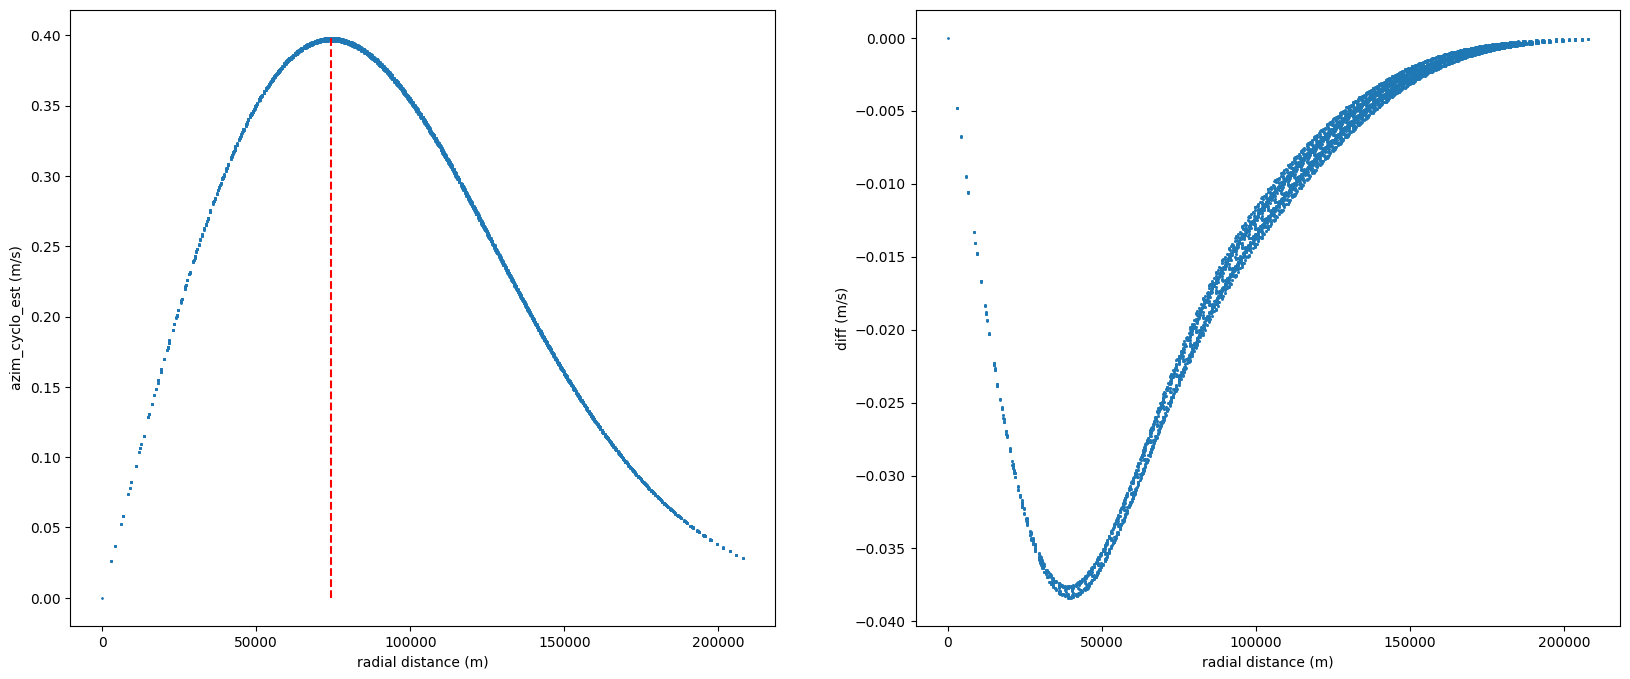

In [26]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_xlabel("radial distance (m)")
ax1.set_ylabel("azim_cyclo_est (m/s)")
ax1.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax1.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
           ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
ax2.set_xlabel("radial distance (m)")
ax2.set_ylabel("diff (m/s)")
ax2.scatter(R.flatten(), (azim_cyclo_est - azim_cyclo).flatten(), s=1)
plt.show()

In [27]:
np.std(azim_cyclo), ge.compute_rmse(azim_cyclo, azim_cyclo_est), ge.compute_mape(azim_cyclo, azim_cyclo_est), ge.compute_cor(azim_cyclo, azim_cyclo_est)

/home/bertrava/projects/jaxparrow/tests/gaussian_eddy.py:60: RuntimeWarning: divide by zero encountered in divide
  ape = np.abs((vel - vel_est) / vel)


(0.11312932971986592,
 0.016468574105311697,
 0.03842319580045764,
 0.9973747506407723)

### Iterative estimation

$\mathbf{u}^{(n+1)} = \mathbf{u_g} + \frac{\mathbf{k}}{f} \times (\mathbf{u}^{(n)} \cdot \nabla \mathbf{u})^{(n)}$

In [28]:
u_cyclo, v_cyclo = cyclo.iterative(u_geos, v_geos, dXY, dXY, dXY, dXY, coriolis_factor, coriolis_factor)

  2%|▏         | 2/100 [00:00<00:00, 964.87it/s]


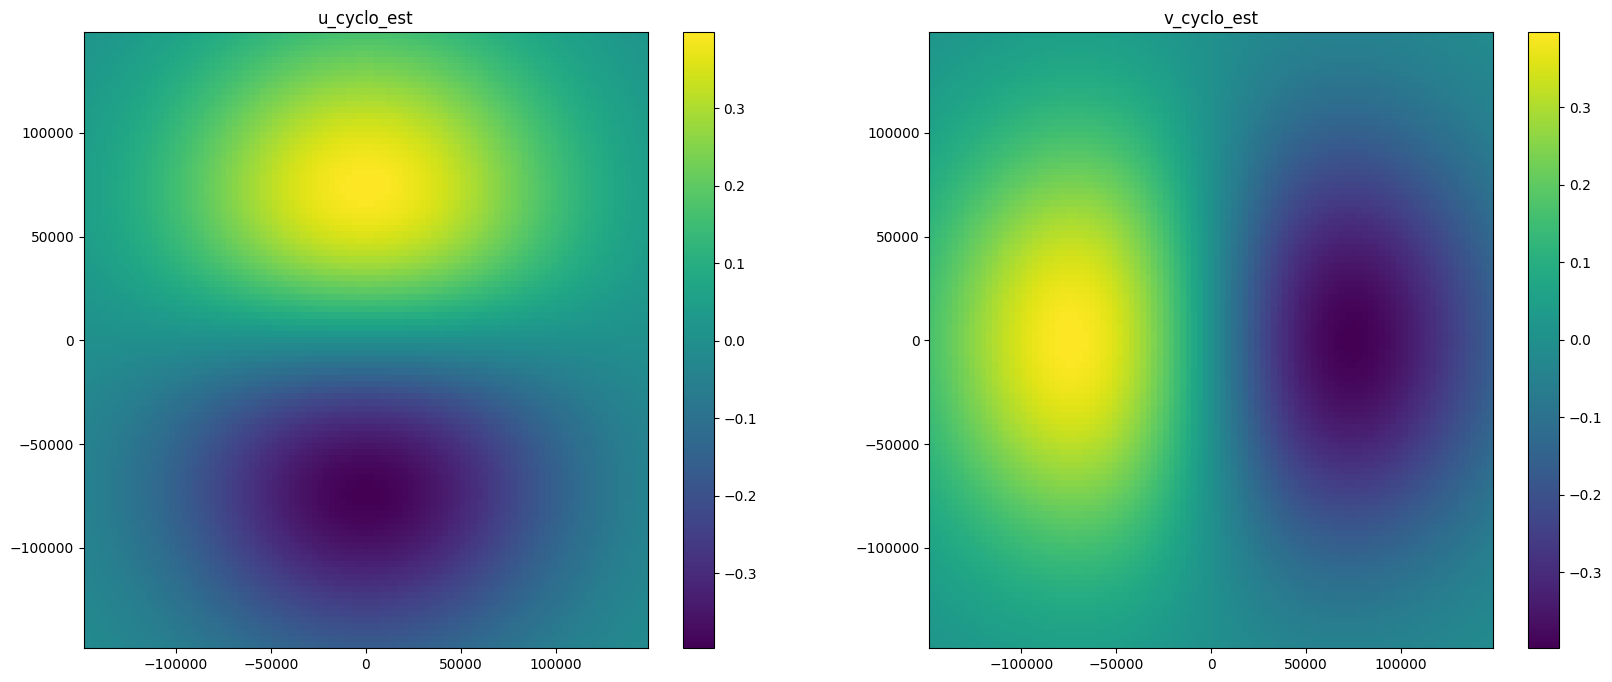

In [29]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("u_cyclo_est")
im = ax1.pcolormesh(X, Y, u_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("v_cyclo_est")
im = ax2.pcolormesh(X, Y, v_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

In [30]:
azim_cyclo_est = ge.compute_azimuthal_magnitude(u_cyclo_est, v_cyclo_est)

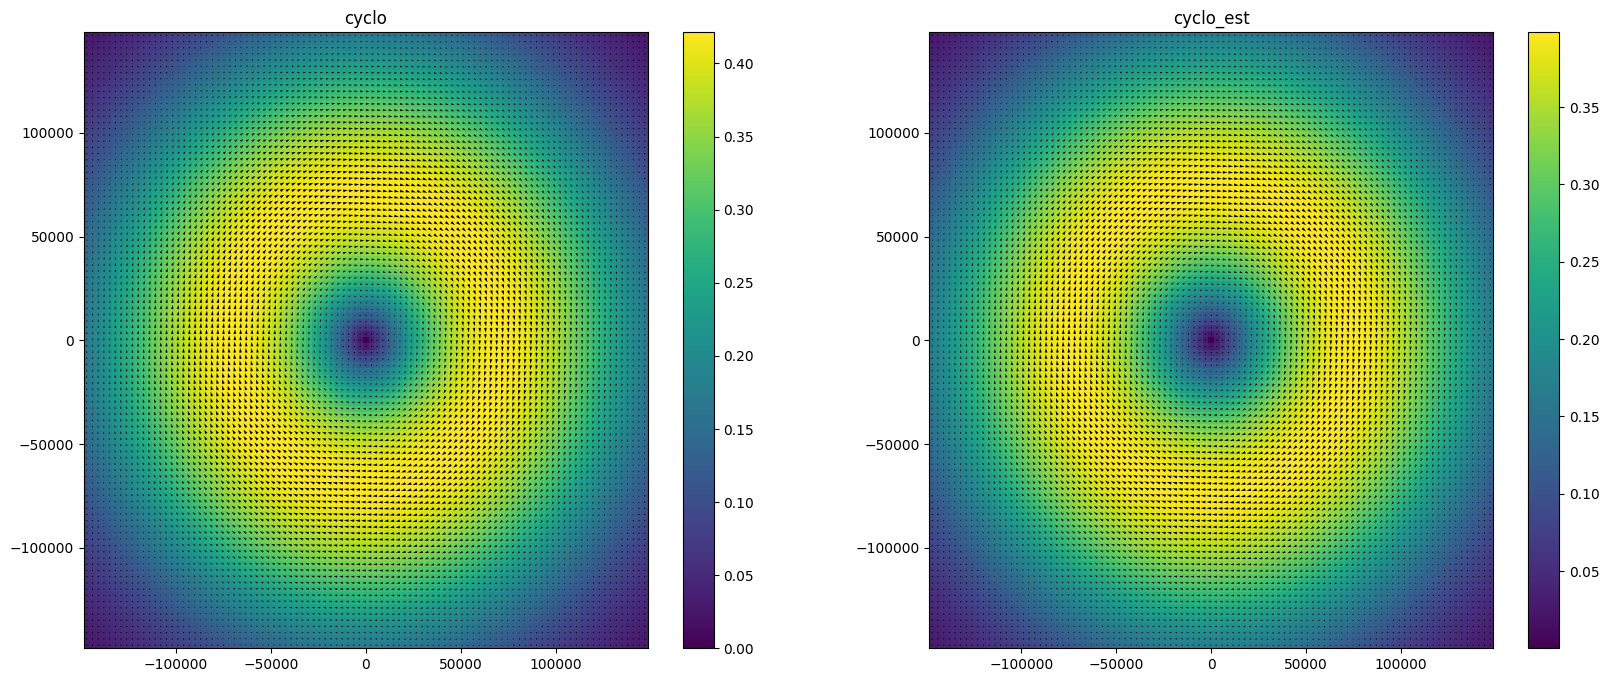

In [31]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("cyclo")
im = ax1.pcolormesh(X, Y, azim_cyclo, shading="auto")
plt.colorbar(im, ax=ax1)
ax1.quiver(X, Y, u_cyclo, v_cyclo, color='k')
ax2.set_title("cyclo_est")
im = ax2.pcolormesh(X, Y, azim_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax2)
ax2.quiver(X, Y, u_cyclo_est, v_cyclo_est, color='k')
plt.show()

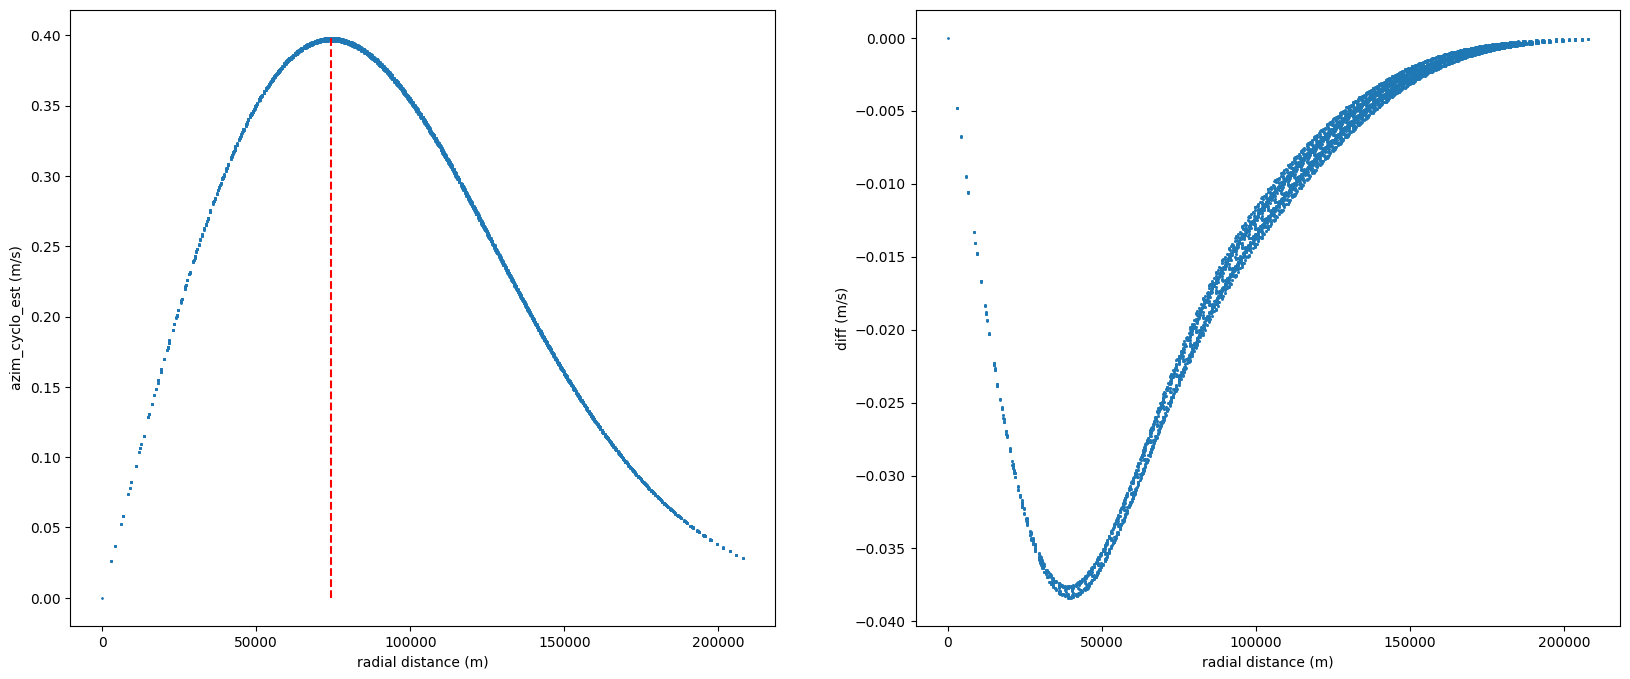

In [32]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_xlabel("radial distance (m)")
ax1.set_ylabel("azim_cyclo_est (m/s)")
ax1.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax1.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
           ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
ax2.set_xlabel("radial distance (m)")
ax2.set_ylabel("diff (m/s)")
ax2.scatter(R.flatten(), (azim_cyclo_est - azim_cyclo).flatten(), s=1)
plt.show()

In [33]:
np.std(azim_cyclo), ge.compute_rmse(azim_cyclo, azim_cyclo_est), ge.compute_mape(azim_cyclo, azim_cyclo_est), ge.compute_cor(azim_cyclo, azim_cyclo_est)

(0.11312932971986592,
 0.016468574105311697,
 0.03842319580045764,
 0.9973747506407723)